In [1]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
 

In [2]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [3]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts = [], xlim=[], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize'] = [20, 4]
    # plt.subplot(6,1,1)
    fig, ax1 = plt.subplots()
    ax1.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    
    for pt in theftpts:
        plt.axvline(pt)
    plt.show()


In [134]:
def plot_Results(df, df_clean, result_df, xlim = [], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize']=[16,12]
    fig, axi = plt.subplots(4, 1)
    axi[0].plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    #plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    axi[0].set_title('Original FuelData vs Time')
    axi[0].set_xlabel('time')

    axi[1].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[1].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[1].set_ylabel('FuelVoltage', color='b')
    axi[1].tick_params('y', colors='b')
    if len(ylim1)!=0:
        axi[1].set_ylim(ylim1)

    ax2 = axi[1].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Cleaned Data')
    
    axi[2].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[2].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[2].set_ylabel('FuelVoltage', color='b')
    axi[2].tick_params('y', colors='b')
    if len(ylim1)!=0:
        axi[2].set_ylim(ylim1)

    ax2 = axi[2].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
        
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Final Predicted Theft Pts - ZOOMED')

    for pt in result_df.theft_index:
        plt.axvline(pt)

    axi[3].plot(result_df.theft_index, result_df['fuel_jump'], 'g-', markersize=3, linewidth=1);
    axi[3].set_title('Fuel/km Ratio at Predicted theft pts - ZOOMED')
    
    axi[3].set_xlabel('time index')
    
    fig.tight_layout()

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

Text(0.5,1,'Simple plot')

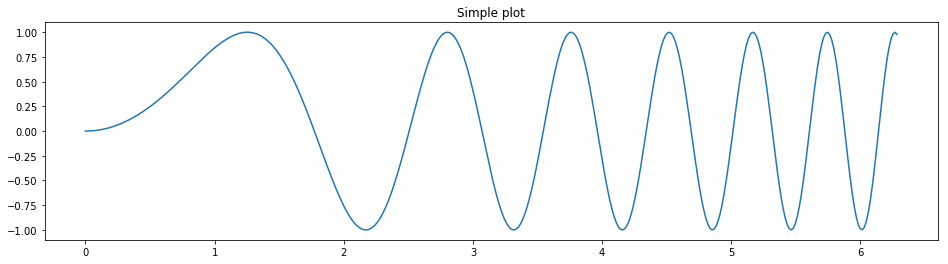

In [108]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

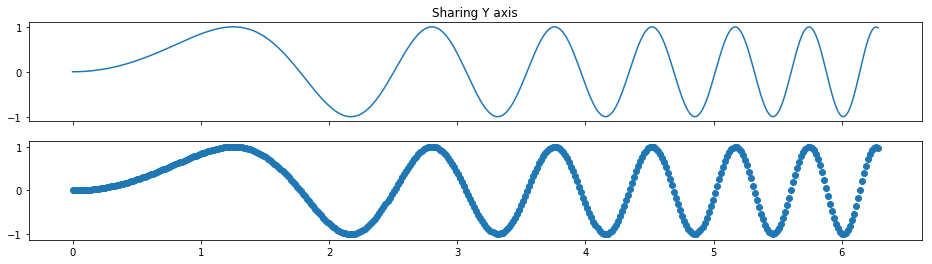

In [117]:
#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

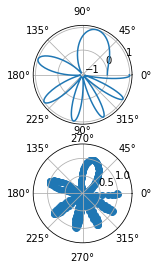

In [122]:
#Creates four polar axes, and accesses them through the returned array

fig, axes = plt.subplots(2, 1, subplot_kw=dict(polar=True))
axes[0].plot(x, y)
axes[1].scatter(x, y)

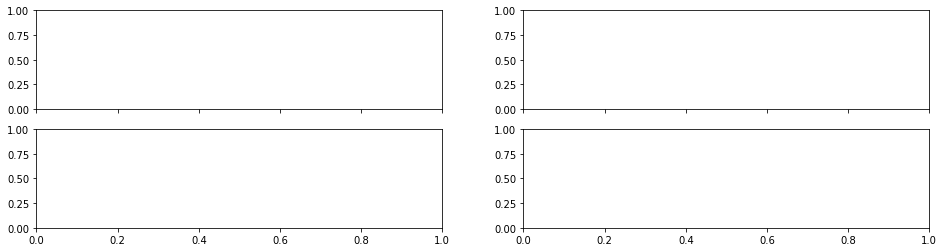

In [113]:
#Share a X axis with each column of subplots

plt.subplots(2, 2, sharex='col');


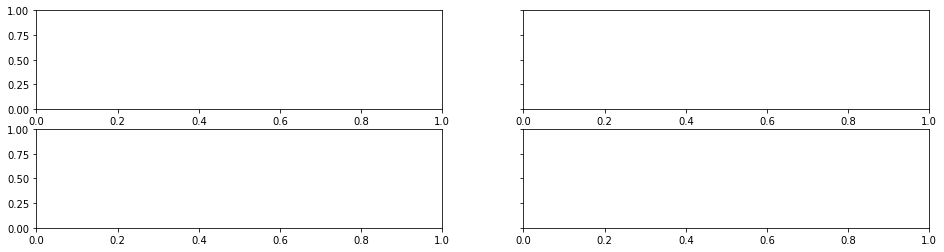

In [114]:
plt.subplots(2, 2, sharey='row');
#Share a Y axis with each row of subplots

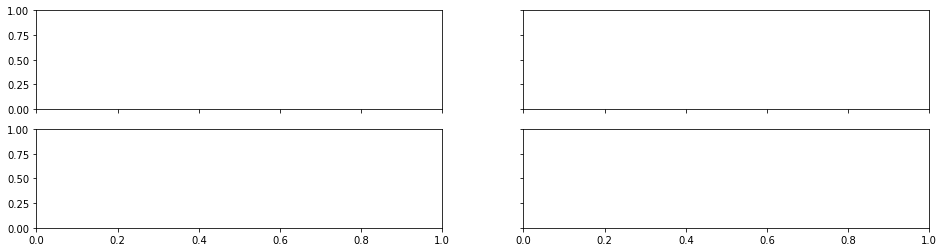

In [115]:
#Share both X and Y axes with all subplots
plt.subplots(2, 2, sharex='all', sharey='all');

In [5]:
folderpath = r"G:\Analytics\FuelAnalysis\test2"
savePath = r"G:\Analytics\FuelAnalysis\results"
filepath = r""
fuelMax = 100
df_list, filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=4)
ctr = 0
def formatDf(df):
    #df_list[0].info()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) +" Preformatting Done")

    dff = dr.perform_postFormating(df)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff

def cleanDF(dff):
    df_clean = dc.Clean_NoiseData(dff, level= 6)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean):
    theft_pts = dc.theft_point(df_clean, tlevel= 0.01)
    print("Dataset_" + str(ctr + 1) + " Theft points Indentified")
    return theft_pts

    

G:\Analytics\FuelAnalysis\test2\cordinates_007042639339.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042640749.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042641148.csv
G:\Analytics\FuelAnalysis\test2\cordinates_008527948598.csv


In [6]:
#plotData_profiles(df)
df = df_list[2]
df = df[:]
df = df.reset_index(drop= True)
df.st = df.io_state.apply(lambda x: x[1])
dis = df[df.st == '0'].distance.apply(lambda x: int(x))

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


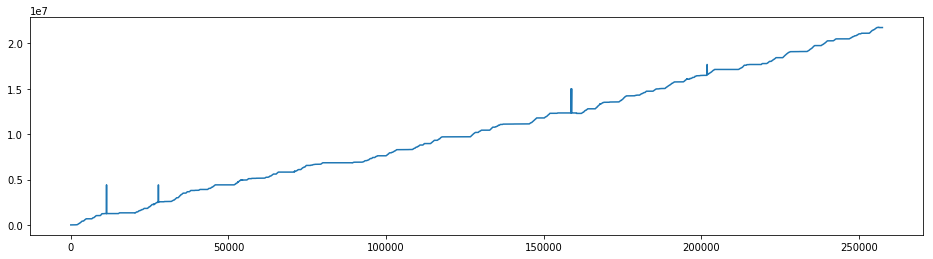

In [7]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dis)

In [8]:
dff = formatDf(df.copy())
Dmax = dff.distance.max()

Dataset_1 Preformatting Done
Dataset_1 Postformatting Done


In [9]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53428 entries, 0 to 53427
Data columns (total 7 columns):
datetime       53428 non-null datetime64[ns]
lat            53428 non-null float64
long           53428 non-null float64
speed          53428 non-null float64
distance       53428 non-null float64
fuelVoltage    53428 non-null float64
dev_state      53428 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 2.9 MB


In [10]:
sum(dff[dff.dev_state==0].fuelVoltage <3)

0

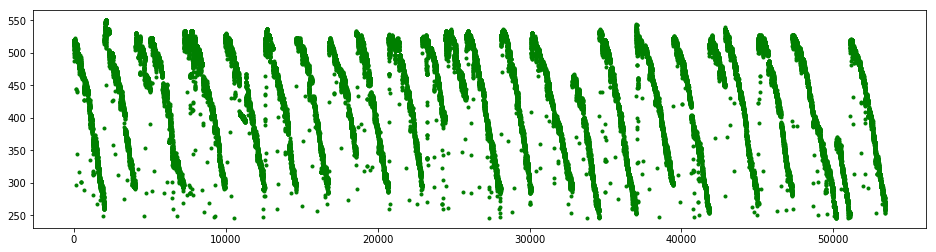

In [11]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dff.index, dff.fuelVoltage,'g.');


In [12]:
dff.fuelVoltage.median()

439.0

In [13]:
dff.fuelVoltage.std()

77.1026587467118

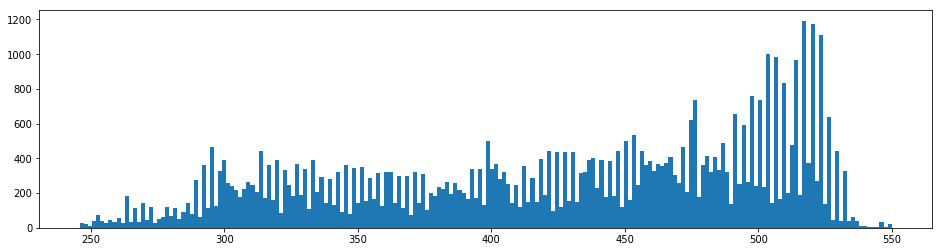

In [14]:
plt.rcParams['figure.figsize'] = [16,4]
plt.hist(dff.fuelVoltage,200);
#plt.xlim(0,0.02)
#plt.ylim(0,2.5)

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


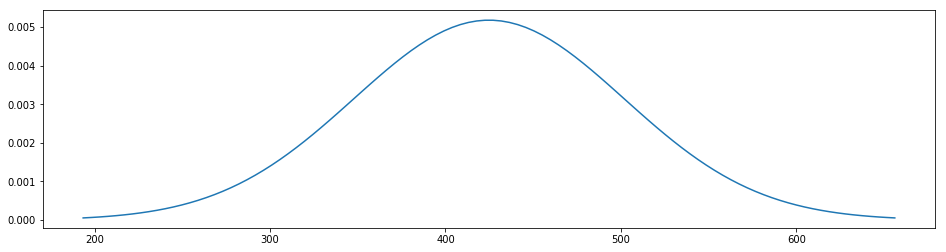

In [15]:
import matplotlib.mlab as mlab
mu = dff.fuelVoltage.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dff.fuelVoltage.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))

In [16]:
dff[(dff.fuelVoltage == 0)  & (dff.dev_state == 1)]

,datetime,lat,long,speed,distance,fuelVoltage,dev_state


In [17]:
df_clean = cleanDF(dff.copy())

Dataset_1 Data Cleaning Done


In [18]:
theft_pts = findtheft(df_clean)

**
281
Dataset_1 Theft points Indentified


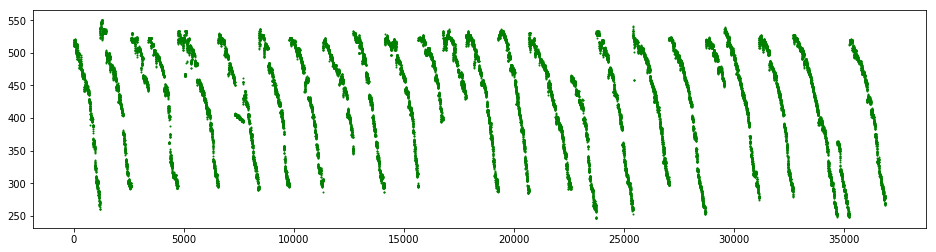

In [30]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(df_clean.index, df_clean.fuelVoltage,'g.', markersize = 2)

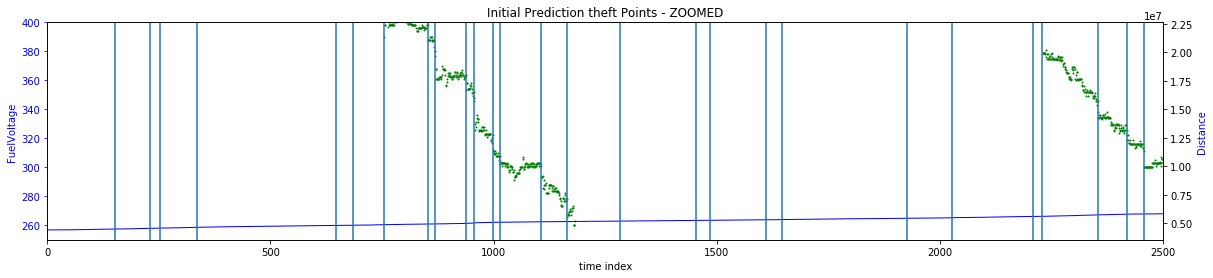

229


In [105]:
xlim = [0,2500]
ylim = [250,400]
plot_theftpts(df_clean,theft_pts, xlim = xlim, ylim1= ylim)
result_df = dc.generate_PredictTable(df_clean,theft_pts,float(1), 1)

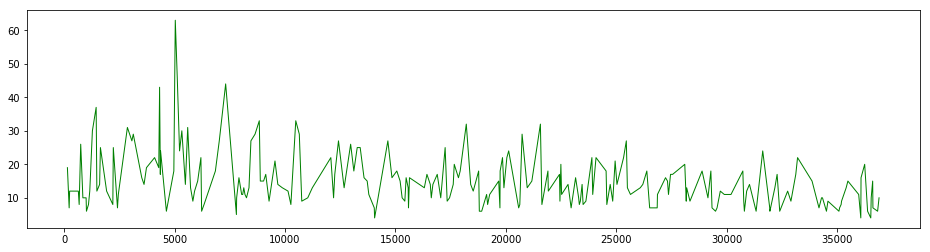

In [106]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(result_df.theft_index, result_df['fuel_jump'], 'g-', markersize=3, linewidth=1);
#plt.ylim(0,400)

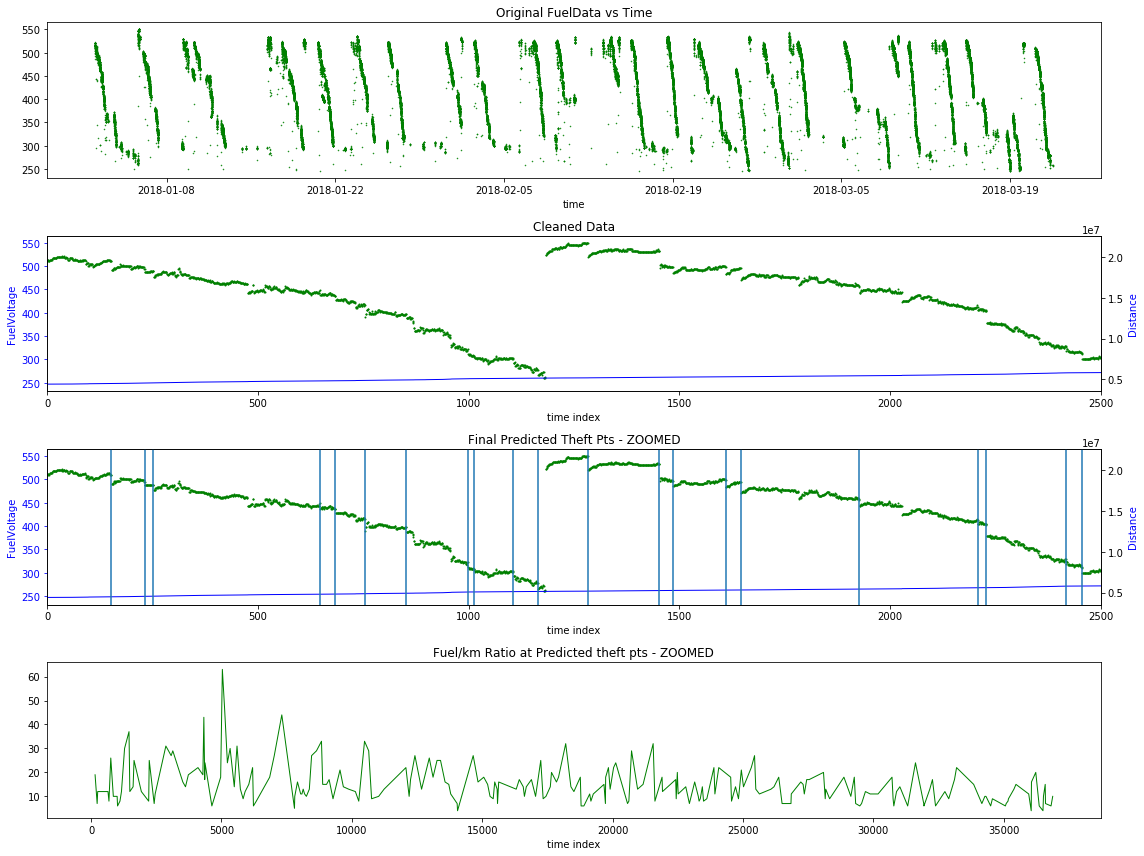

     theft_index        lat       long          theft_time  fuel_jump  dist_jump(KM)       time_jump  Possibility  FuelPerKM
0            152  24.374520  78.538627 2018-01-02 04:32:27       19.0          3.988 0 days 00:45:56         True   4.764293
1            231  23.896742  78.766580 2018-01-02 06:23:41        7.0          3.475 0 days 00:03:28         True   2.014388
2            252  23.779955  78.808640 2018-01-02 06:44:13       12.0          5.410 0 days 00:21:22         True   2.218115
4            647  22.643562  80.069647 2018-01-02 15:57:20       12.0          1.923 0 days 00:02:30         True   6.240250
5            684  22.622747  80.247662 2018-01-02 16:23:52        8.0          1.617 0 days 00:02:33         True   4.947434
6            754  22.492670  80.518318 2018-01-02 17:45:41       26.0          9.001 0 days 01:26:36         True   2.888568
7            852  22.275203  81.015892 2018-01-02 20:10:45       10.0          2.600 0 days 00:04:29         True   3.846154


In [135]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)

plot_Results(dff,df_clean,result_df, xlim = xlim, ylim1=[]);
#ctr+=1
print(result_df)

In [84]:
def findAVG(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    avgDT = []
    avgdt_lst = []
    dt = 100
    mean_lst = []
    median_lst = []
    mode_lst = []
    ctr = 0
    print(Dmax)
    while dt < 20000:
        avgDT = []
        #print (dt)
        i=0
        while i<len(cleanDf): 
            ds = 0
            dsRef = cleanDf.distance[i]
            dfRef = cleanDf.fuelVoltage[i]
            while ((ds)<=dt  and i<len(cleanDf)):
                ds = (cleanDf.distance[i] - dsRef)
                i+=1
                #print(i)

            if i<len(cleanDf):
                df = dfRef- cleanDf.fuelVoltage[i]
                if df>0 :
                    avg = df/ds
                    avgDT.append(avg)
            #print(df)
        avgdt_lst.append(avgDT)
        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        mode = pd.Series(avgDT).mode()
        #print (med,mean,mode)

        median_lst.append(med)
        mean_lst.append(mean)
        mode_lst.append(mode)
        ctr+=1
        dt += 500
        print (dt)

        
    return [median_lst,mean_lst,mode_lst], avgdt_lst

central_DT, avgLst = findAVG(df_clean, Dmax)

21764223.0
600
1100
1600
2100
2600
3100
3600
4100
4600
5100
5600
6100
6600
7100
7600
8100
8600
9100
9600
10100
10600
11100
11600
12100
12600
13100
13600
14100
14600
15100
15600
16100
16600
17100
17600
18100
18600
19100
19600
20100


In [85]:
len(df_clean), len(avgLst)

(36902, 40)

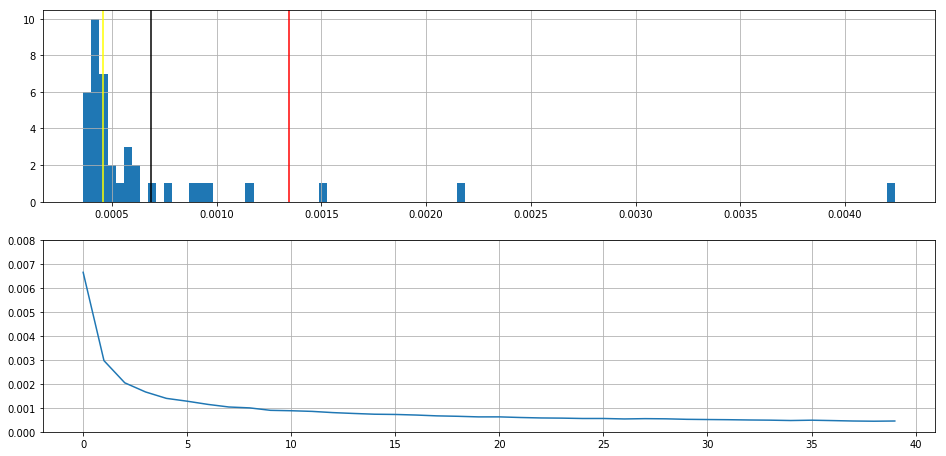

In [100]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.hist(central_DT[0],bins =100);
plt.grid()
plt.axvline(pd.Series(central_DT[0]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT[0]).median(), color = 'yellow')
plt.axvline(2*pd.Series(central_DT[0]).std(), color = 'Red')

#plt.ylim(0,.005)
plt.subplot(3,1,2)
plt.plot(central_DT[1]);
plt.ylim(0,.008)
plt.grid()

#plt.plot(central_DT[2]);

        

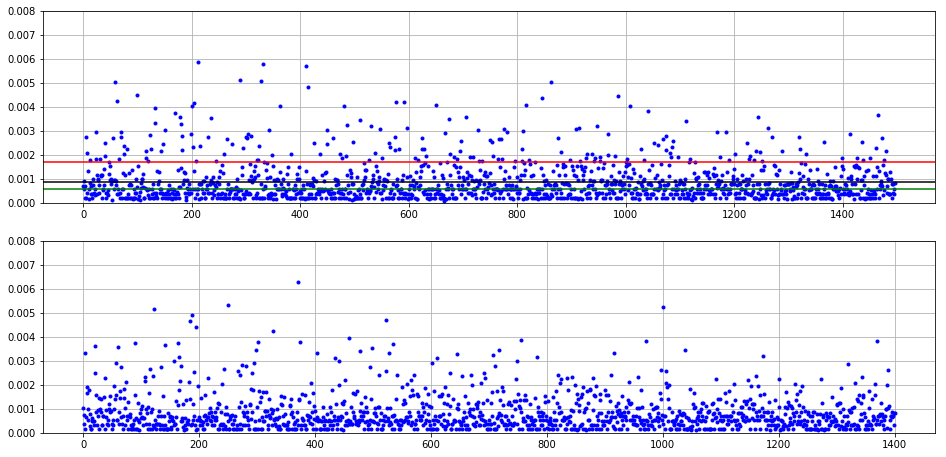

In [104]:
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.plot(avgLst[10],'b.');
plt.grid()
plt.ylim(0,.008)

plt.axhline(pd.Series(avgLst[10]).mean(), color = 'black')
plt.axhline(pd.Series(avgLst[10]).median(), color = 'green')
plt.axhline(2*pd.Series(avgLst[10]).std(), color = 'Red')
#plt.xlim(0,500)
plt.subplot(3,1,2)
plt.plot(avgLst[11], 'b.');
plt.ylim(0,.008)
plt.grid()

In [37]:
(central_DT[0])

[0.00423728813559322,
 0.00370599276656137,
 0.002145922746781116,
 0.0012015621390621392,
 0.0008741258741258741,
 0.000611807892321811,
 0.0005079236082893133,
 0.00042354934349851756,
 0.00038483741421071343,
 0.0003471806831235289,
 0.0003360128201814469,
 0.00035339851572623396,
 0.0003287548421880371,
 0.0003168123899429929,
 0.0003336410585309856,
 0.0003450953325856268,
 0.0003460599082941243,
 0.00035913586385988175,
 0.00035675345107654576,
 0.00033755824412657037,
 0.000335366275290766,
 0.0003301820963595444,
 0.0003245083738139342,
 0.00032830333452649413,
 0.00029574991006683763]

In [ ]:
plt.hist(avgDT[abs(avgDT - avgDT.mean()) < 3*avgDT.std()],bins = 200)
plt.axvline(avgDT.median(), color = 'black')
plt.axvline(avgDT.mean(), color = 'green')

In [ ]:
a = avgDT.value_counts()
avgDT.median(), avgDT.mean(), avgDT.mode()

10km:
mean = 0.0167
median = 0.0131
mode = 0.0037

1km:
mean = 0.0095
median = 0.00562
mode = 0.00187

5km:
mean = 0.00138
median = 0.00936
mode = 0.00187

0.5Km
mean = 0.00138
median = 0.00936
mode = 0.00187

50km
mean = 0.0373
median = 0.0365
mode = 0.0411

100km
mean = 0.065988
median = 0.0692
mode = 0.048689









In [ ]:
plt.plot(df_clean.distance * .001*Dmax, df_clean.fuelVoltage,  'g.')